In [19]:
from sklearn. preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier

from tabulate import tabulate
from numba import njit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

class Classify:
    """Docstring Placeholder"""
    
    def __init__(self):
        
        self.X = None
        self.y = None
        
        self.N = None
        self.M = None
        
        self.C = None
        self.L = None
        
        # This is where we will keep all the classifiers.
    
        self.fits = dict()
        
        # This says if data is valid. True unless shown to be false.
        
        self.data_valid = True
        
        # This is for y with more than one level.
        
        self.label_bins = None
        
        self.priors = None
        
        self.label = None
        self.label_position = None
        
        self.folds = None

        
    ###################################################################################
    ###################################################################################
        
    def data(self, X, y, level_order = None, label = None, priors = None, folds = None):
        
        # Check if input types are the correct types.
        
        if not isinstance(X,pd.DataFrame):
            try:
                X = pd.DataFrame(X)
            except:
                print('X must covertable to pd.DataFrame!')
                self.data_valid = False
    
        if not isinstance(y, pd.Series):
            if isinstance(y,pd.DataFrame):
                if y.shape[1] == 1:
                    y = pd.Series(y)
                else:
                    print('y must have one column!')
                    self.data_valid = False
            else:
                try:
                    y = pd.Series(y)
                except:
                    print("y must be convertable to a pd.Series!")
                    self.data_valid = False
                    
        if y.dtype != np.dtype('O'):
            print('y must be of dtype Object with each element of type str!!')
            self.data_valid = False
    
        # Check to make sure factors and response have the same number of rows.
        
        if X.shape[0] != y.shape[0]:
            print("X and y must have same number of rows!")
            self.data_valid = False
        
        # Remove rows that contain None or NaN or +- inf
        
        remove = (~np.isfinite(X)).sum(axis=1) + y.isnull()
        remove_sum = remove.sum()
        if remove_sum > 0:
            X.drop(remove,axis=0)
            y.drop(remove)
            print('There were ' + str(remove_sum) + ' rows removed due to missingness or inf.')
            
        # N is rows and M is columns
        self.N = X.shape[0]
        self.M = X.shape[1]
    
        # C is the unique categories
        # L is the number of categories
        
        C = y.unique()
        self.L = len(C)
        
        # make sure there are al least two levels!
        # while is is more propery 'validation'
        # it most naturally fits here.
        
        if self.L <= 1:
            print("There needs to be two or more levels in y!")
            self.data_valid = False
            return
    
        # Put in lexographical order if no order specified.
        
        if level_order == None:
            C.sort()
        elif not sum(np.sort(C) == np.sort(level_order)):
            C = level_order
        else:
            print('There was a problem with level_order!')
            self.data_valid = False
            return
        
        # assign as attribute
        
        self.C = C
        
        X, y = shuffle(X,y)
        
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        
       
        self.label_bins = label_binarize(y.values, classes=self.C)
        
        if self.L == 2:
            self.label_bins = np.append(self.label_bins,1-self.label_bins,axis=1)
        
        self.label_bins = np.array(self.label_bins,dtype=bool)
        
        if label == None and self.L != 2:
            self.label_position = self.L
            self.label = "Averaged"
        elif label == None and self.L == 2:
            self.label_position = self.L-1
            self.label = self.C[-1]
        elif label in self.C:
            self.label_position = np.where(self.C == label)[0][0]
            self.label = label
        else:
            print('Label is not in y!')
            self.data_valid = False
            return
        
        if priors == None:
            self.priors = np.append(y.value_counts(normalize=True)[self.C].values,1/self.L)
        elif len(priors) == self.L:
            priors = np.array(priors)
            self.priors = priors/sum(priors)
        else:
            print('The length of your priors is not right!')
            self.data_valid = False
            return
        
        sc = StandardScaler()
        X = sc.fit_transform(X)
        X = pd.DataFrame(X)
        
        if folds == None:
            self.folds = 3
        elif 1 < folds <= self.N:
            self.folds = folds
        else:
            print('Too many or two few cross validation folds!')
            self.data_valid = False
            
        if self.data_valid:
            print("Your data has been validated to work with sklearn.\n")
            
            self.X, self.y = X, y
            
        else:
            print('Your data has has errors!')
        
        dims = [['N Rows',self.N],['M Columns',self.M],['levels',self.L]]
        
        print(tabulate(dims,headers=['Name','Value']))
        
        dims2 = []
        for i in range(self.L):
            dims2.append([self.C[i], self.priors[i]])
        
        print('\n')
        print(tabulate(dims2,headers=['Levels','Prior']),end='\n\n')
        
        
        
    ################################################################################
    ################################################################################
    
    def add_fit(self, clf, name=None, replace=False):
        
        if not self.data_valid:
            print('Data is not valid!')
            return
        
        # Figure out what the name should be
        
        if not replace:
            if name == None:
                name = clf.__class__.__name__   
            elif not isinstance(name,str):
                print('Name must be a string!')
                return
        
            if name in self.fits:
                i = 1
                while name + str(i) in self.fits:
                    i += 1
            
                name = name + str(i)
            print('Processing ', end = '')
        else:
            print('Replacing ', end = '')
        print(str(name) + ':', end = '')
        #############################################################
        
        def crossval(clf):        
            
            probs = np.zeros(shape=(self.N,self.L))
            with warnings.catch_warnings(record=True) as warn:
                warnings.simplefilter("once")

                kf = KFold(n_splits=self.folds)
                kf.get_n_splits(self.X)
       
                for train, test in kf.split(self.X):
                    
                    if self.M != 2:
                        X_train = self.X.iloc[train,:]
                        X_test = self.X.iloc[test,:]
                    else:
                        X_train = self.X.iloc[train]
                        X_test = self.X.iloc[test]
                    
                    y_train = self.y[train]
                    
                    cbc = CalibratedClassifierCV(clf,cv=2)
                    cbc.fit(X_train,y_train)
                    probs[test] = cbc.predict_proba(X_test)

            return(probs, warn)
            #n = [self.N for i in range(self.L+1)]
            #return(np.repeat(self.priors,n).reshape(self.L+1,self.N).T,[])

        def compute_curves(probs):
            res = 100
            
            points = np.linspace(0,1,num=res)
            
            @njit
            def fast_curve(L,label_bins,probs,priors):
                prec = np.zeros(shape=(res,L+1))
                recall = np.zeros(shape=(res,L+1))
                for i in range(L):
                    n_positives = label_bins[:,i].sum()
                    for j, k in enumerate(points):
                        pred = probs[:,i] >= k
                        if pred.sum():
                            tp = label_bins[pred,i].sum()
                            prec[j,i] = tp/pred.sum()
                            recall[j,i] = tp/n_positives
                        else:
                            prec[j,i] = 1
                            recall[j,i] = 0
            
                for i in range(L):
                    for j in range(res):
                        prec[j,L] += prec[j,i]*priors[i]
                        recall[j,L] += recall[j,i]*priors[i]
                
                return(prec,recall)
                            
            prec, recall = fast_curve(self.L,self.label_bins,probs,self.priors)   
            return({'prec': prec, 'recall': recall})
        

        def compute_metrics(probs):
            pr_vals = np.zeros(shape=(self.folds+1,self.L+1))
            kf = KFold(n_splits=self.folds)
            kf.get_n_splits(self.X)
       
            for i in range(self.L):
                pr_vals[0,i] = average_precision_score(self.label_bins[:,i],probs[:,i])
                for j, (_, test) in enumerate(kf.split(self.X)):
                    pr_vals[j+1,i] = average_precision_score(self.label_bins[test,i],
                                                             probs[test,i])
            
                    pr_vals[0,self.L] = average_precision_score(self.label_bins,probs[:,:self.L],
                                                                    average='weighted')
                    pr_vals[j+1,self.L] = average_precision_score(self.label_bins[test,:self.L],
                                                                  probs[test,:self.L],
                                                                    average='weighted')
            pr_mean = pr_vals[0,:]
            pr_levelstd = np.std(pr_vals[1:,:],axis=0)
            
            pr_cvsmean = pr_vals[:,self.L]
            pr_cvstd = np.std(pr_vals[:,:self.L],axis=1)

            return({'pr_mean': pr_mean, 'pr_levelstd': pr_levelstd, 
                    'pr_cvsmean':pr_cvsmean, 'pr_cvstd': pr_cvstd})

        try:
            with warnings.catch_warnings(record=False):
                warnings.simplefilter("ignore")
                clf.fit(self.X.iloc[:20,:],self.y.iloc[:20])
        except ValueError as val:
            print('Fit error: ',end='')
            print(val)
            return
        
        ##################################################
        
        probs, warn = crossval(clf)
        curves = compute_curves(probs)
        metrics = compute_metrics(probs)
        
        self.fits[name] = {'clf': clf, 'probs': probs, 'curves': curves, 'metrics': metrics}
        
        if len(warn) > 0:
            print('\n')
            print(warn[0].message)
            print('\n' + 'Added Anyway.' + '\n')
        else:
            print(' Added.')
        
    def remove_fit(self,name):
        if name in self.fits:
            del self.fits[name]
        else:
            print('Key ' + name + ' not in fits.')
    
    def list_fits(self):
        for i in self.fits:
            print(i)
    
    def compare(self, label=None, topn = -1):
        import matplotlib.pyplot as plt
        from tabulate import tabulate
        
        if not self.data_valid:
            print('Data is not valid!')
            return
        
        if label == None:
            label = self.label
            label_position = self.label_position
        elif label in self.C:
            label_position = np.where(self.C == label)[0][0]
        elif label == 'average':
            label = 'Averaged'
            label_position = self.L
        else:
            print('Label is not in y!')
            return
        
      
        if label == 'Averaged':
            print('\nAP is averaged across all levels and cross validation subsets. \n')
        else:
            print('\nPositive label is ' + label + '\n')
        
        priorp= self.priors[label_position]
        
        if label == 'Averaged':
            headers = ['Model Name','E(AP)','SD(AP|Average Level)','SD(AP|Cross Validations)']
            metrics = []
            for i in self.fits:
                metrics.append([i,self.fits[i]['metrics']['pr_mean'][label_position],
                                  self.fits[i]['metrics']['pr_levelstd'][label_position],
                                  self.fits[i]['metrics']['pr_cvstd'][label_position]])
        else:
            headers = ['Model Name','E(AP)','SD(AP|level=' + label + ')']
            metrics = []
            for i in self.fits:
                metrics.append([i,self.fits[i]['metrics']['pr_mean'][label_position],
                                  self.fits[i]['metrics']['pr_levelstd'][label_position]])
        
        metrics.sort(reverse=True, key=lambda x: x[1])
        if topn >= 1:
            metrics1 = metrics[:int(topn)]
            metrics2 = metrics1.copy()
        else:
            metrics1 = metrics
            metrics2 = metrics1.copy()
            
        metrics2.append(['random',priorp])
        metrics2.append(['perfect',1])
        
        metrics2.sort(reverse=True, key=lambda x: x[1])
        
        print(tabulate(metrics2,headers=headers))
        
        for name in [i[0] for i in metrics1]:
            x = self.fits[name]['curves']['recall'][:,label_position]
            y = self.fits[name]['curves']['prec'][:,label_position]
            plt.plot(x,y,label=name)

        plt.title(label + ' Precision Recall Curve')
        plt.legend(bbox_to_anchor=(1.04,.5), loc='center left')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
          
    def inspect(self,name):
        
        if name not in self.fits:
            print('Your model does not exist!')
            return        
        
        headers = ['Level Name','E(AP|Level)','SD(AP|Level)']
        metrics = []
        for i, j in enumerate(self.C):
            metrics.append([j,self.fits[name]['metrics']['pr_mean'][i],
                              self.fits[name]['metrics']['pr_levelstd'][i]])
        
        metrics.append(['Averaged',self.fits[name]['metrics']['pr_mean'][self.L],
                                   self.fits[name]['metrics']['pr_levelstd'][self.L]])
            
        print(tabulate(metrics,headers=headers),end='\n\n')
        
        headers = ['Cross Validation','E(AP|Cross Validation)','SD(AP|Cross Validation)']
        cvs = []
        for i in range(self.folds):
            cvs.append([i,self.fits[name]['metrics']['pr_cvsmean'][i],
                              self.fits[name]['metrics']['pr_cvstd'][i]])
        
        cvs.append(['Averaged',self.fits[name]['metrics']['pr_cvsmean'][self.folds],
                                   self.fits[name]['metrics']['pr_cvstd'][self.folds]])
        
        print(tabulate(cvs,headers=headers),end='\n\n')
        
        
        for i in range(self.L):
                plt.plot(self.fits[name]['curves']['recall'][:,i], 
                         self.fits[name]['curves']['prec'][:,i],label=self.C[i])

        plt.plot(self.fits[name]['curves']['recall'][:,self.L],
                     self.fits[name]['curves']['prec'][:,self.L],label='Averaged')
        
        plt.title(' Precision Recall Curve')
        plt.legend(bbox_to_anchor=(1.04,.5), loc='center left')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        
    def suite(self, max_iter = 100000):
        
        print('Adding a suite of classifiers with default parameters.\n')
        self.add_fit(GaussianNB())
        
        self.add_fit(LinearSVC(max_iter= max_iter))
        self.add_fit(SVC())
        
        self.add_fit(DecisionTreeClassifier())
        self.add_fit(ExtraTreeClassifier())
        
        self.add_fit(AdaBoostClassifier())
        self.add_fit(BaggingClassifier())
        self.add_fit(RandomForestClassifier())
        self.add_fit(GradientBoostingClassifier())
       
        self.add_fit(LogisticRegression(max_iter=max_iter))
        self.add_fit(PassiveAggressiveClassifier(max_iter=max_iter))
        self.add_fit(Perceptron(max_iter=max_iter))
        self.add_fit(RidgeClassifier(max_iter=max_iter))
        self.add_fit(SGDClassifier(max_iter=max_iter))
        
        self.add_fit(MLPClassifier(max_iter= max_iter))
        self.add_fit(KNeighborsClassifier())
        print('\nFinished Adding Classifiers\n')

Your data has been validated to work with sklearn.

Name         Value
---------  -------
N Rows         940
M Columns       27
levels           3


Levels                     Prior
----------------------  --------
Controversial           0.126596
Not Controversial       0.645745
Somewhat Controversial  0.22766

Processing GaussianNB: Added.
Processing LinearSVC: Added.
Processing SVC: Added.
Processing DecisionTreeClassifier: Added.
Processing ExtraTreeClassifier: Added.
Processing AdaBoostClassifier: Added.
Processing BaggingClassifier: Added.
Processing RandomForestClassifier: Added.
Processing GradientBoostingClassifier: Added.
Processing LogisticRegression: Added.
Processing PassiveAggressiveClassifier: Added.
Processing Perceptron: Added.
Processing RidgeClassifier: Added.
Processing SGDClassifier: Added.
Processing MLPClassifier: Added.
Processing KNeighborsClassifier: Added.
Finished Adding Classifiers


AP is averaged across all levels and cross validation subsets. 

Model Nam

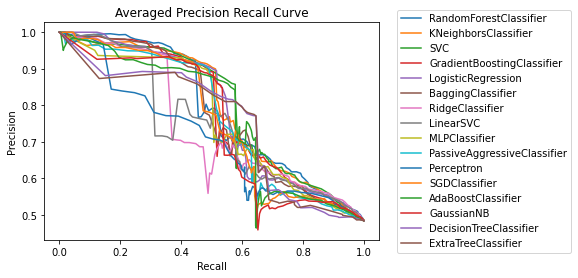

In [20]:
import pandas as pd

X = pd.read_pickle('summaries.pkl')
y = pd.read_pickle('summaries_r.pkl')

#dd = {'Controversial':'1','Not Controversial':'0','Somewhat Controversial': '0'}
#y = y.apply(lambda x: dd[x])
sclf = Classify()
sclf.data(X,y)
sclf.suite()
sclf.compare()


Positive label is Controversial

Model Name                 E(AP)    SD(AP|level=Controversial)
----------------------  --------  ----------------------------
perfect                 1
KNeighborsClassifier    0.401867                     0.0247948
SVC                     0.397069                     0.0470099
RandomForestClassifier  0.37479                      0.0407481
random                  0.126596


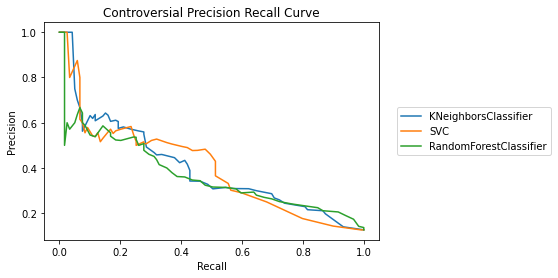

In [22]:
sclf.compare(topn=3,label='Controversial')

Level Name                E(AP|Level)    SD(AP|Level)
----------------------  -------------  --------------
Controversial                0.401867      0.0247948
Not Controversial            0.88918       0.00387156
Somewhat Controversial       0.44745       0.0194285
Averaged                     0.726924      0.00609824

Cross Validation      E(AP|Cross Validation)    SD(AP|Cross Validation)
------------------  ------------------------  -------------------------
0                                   0.726924                   0.219767
1                                   0.726003                   0.211552
2                                   0.727111                   0.230695
Averaged                            0.739458                   0.215215



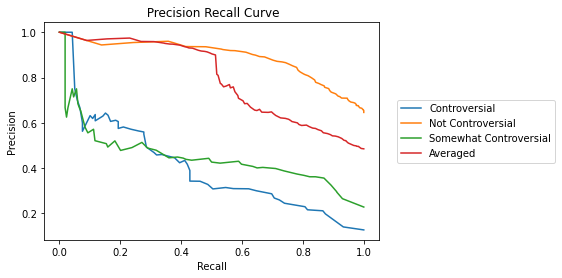

In [23]:
sclf.inspect('KNeighborsClassifier')